# Hands-on session on Digital Volume Correlation with <tt>SPAM

@ Olga Stamati: olga.stamati@esfr.fr

   

## Outline

- What is <tt>SPAM</tt>?
- Let's load an X-ray image
- <font color="red">**Local DVC**</font> 
- Discrete DVC
- Global DVC
- Multimodal registration

## What is <tt>SPAM</tt>?

<tt>SPAM</tt> (**S**oftware for the **P**ractical **A**nalysis of **M**aterials) is an **open-source** <tt>Python</tt> package created for the **analysis** of 2D/3D image data and correlated random fields with applications in material science.<br>

- Documentation: https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/intro.html
- Source code: https://gricad-gitlab.univ-grenoble-alpes.fr/ttk/spam
- Chat room: https://matrix.to/#/#spam:matrix.org

### 1.1 How to install <tt>SPAM?</tt>
----------------------------
* For developers:<br>
`sudo apt install <all dependencies>` <br>
`git clone <url-spam-repo> && cd spam`

-----------------------
* We're on <tt>pip and <tt>conda: <br>
`pip install spam` <br>
`conda install spam`
-----------------------
* We have a <tt>docker image:<br>
`docker pull gricad-registry.univ-grenoble-alpes.fr/ttk/docker-ttk/spam`



### 1.1 Should you install <tt>SPAM</tt> <font color="red">now</font> ?<br>
   
Normally it should be already installed in your bootable ubuntu key (together with jupyter notebook).<br> 
Let's try the following:

In [12]:
import spam.DIC # if this throws no errors, you're all set!

### 1.2 How to run <tt>SPAM</tt> ?<br>
   
- <tt>SPAM</tt> is designed to be a library of canonical functions directly called inside your case-based script:<br>
  
  `reg = spam.DIC.register(im1, im2)` <br>
  

- But it also includes some *macro commands* that tie together a number of the functions available:<br>

  `spam-reg -h`
 
 ----
 We'll use both in this tutorial.

## 2. Let's load an X-ray image



In [10]:
# First we need to import some modules...
import numpy, tifffile
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15

In [96]:
# And now we'll load our image
im = tifffile.imread('./V4/VEC4-01-b2.tif')
print("Image dimensions", im.shape)
print("Image type", im.dtype)

Image dimensions (380, 275, 275)
Image type uint16


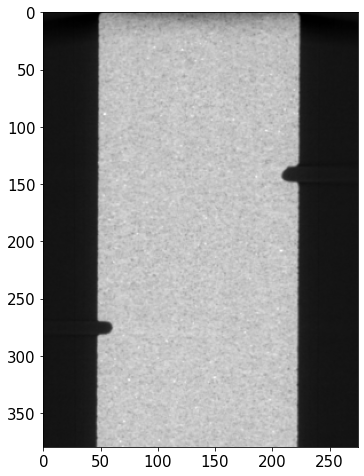

In [117]:
# Let's see the image
plt.figure(figsize=(8, 8))
plt.imshow(im[:, 175, :], cmap='gray')

In [99]:
# Let's see a part of this big 3D matrix...
print(im[:, 175, :])

[[4637 4583 4626 ... 4981 4767 4673]
 [4376 4359 4422 ... 4646 4637 4697]
 [4220 4204 4206 ... 4435 4415 4339]
 ...
 [4712 4598 4875 ... 4921 4927 4788]
 [4678 4493 4771 ... 4718 4792 4729]
 [4687 4757 4762 ... 4452 4769 4812]]


In [6]:
print(f"Max value {im.max()} \nMin value {im.min()}")

Max value 65180 
Min value 0


Text(0, 0.5, 'Count')

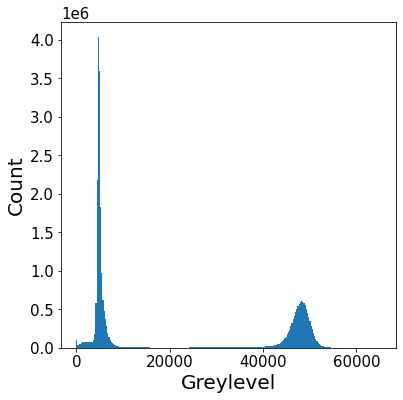

In [65]:
# Plot the grey level histogram
plt.figure(figsize=(6, 6))
plt.hist(im.ravel(), bins=256 )
plt.xlabel("Greylevel", fontsize=20)
plt.ylabel("Count", fontsize=20)

## 2.1 Morphological image analysis 

- Phase segmentation
- Morphological descriptors (volume, surface, orientation etc)
- Meshing the morphology for input into a numerical simulation

---
We're **not** going to discuss about the morphological analysis of our images.<br>
This was already the topic of previous lectures and practical sessions.

## 3. Image Correlation

---
### 3.1 DVC background 
#### <font color="red">**NOTE**</font>: More in-depth on tommorow's lecture with S. Roux
---

Digital Volume Correlation (DVC) aims to measure a **transformation** between two imaged states: $f(x)$ and $g(x)$. <br>

We're trying to find the **deformation function** $\boldsymbol{\Phi}$ that minimises the residual:

### $ \hspace{1.5cm} \mathcal{T}(\boldsymbol{\Phi}) = \sum_{x \in \Omega} \left(f(x) - g(\boldsymbol{\Phi}\cdot x)\right)^2 $

Deformation function in <tt>SPAM</tt>:

$ \hspace{0.5cm} \boldsymbol{\Phi} = \left[
  \begin{array}{cccc}
    {\color{myred}F_{zz}} & {\color{myred}F_{zy}} & {\color{myred}F_{zx}} & {\color{myblue}t_z} \\
    {\color{myred}F_{yz}} & {\color{myred}F_{yy}} & {\color{myred}F_{yx}} & {\color{myblue}t_y} \\
    {\color{myred}F_{xz}} & {\color{myred}F_{xy}} & {\color{myred}F_{xx}} & {\color{myblue}t_x} \\
    0 & 0 & 0 & 1
  \end{array}\right] \hspace{0.9cm} \text{with} \ \ x = \left(\begin{array}{c} z \\ y \\ x \\ 1 \end{array} \right) \hspace{0.9cm} \text{and} \ \ x' = \boldsymbol{\Phi}\cdot x$  
  
 ---
 $\hspace{0.5cm} \boldsymbol{\Phi}$ is a **linear** and **homogeneous** operator, accounting for:
   - translation
   - rotation
   - normal strain
   - shear strain


### Resolution scheme in <tt>SPAM</tt>:

A Gauss-Newton **iterative** scheme is implemented based on a 1st order Taylor expansion of the updated deformed image $\widetilde g$ for **small** corrections of $\delta\boldsymbol \Phi$: <br>

$ \hspace{0.8cm} g(\boldsymbol \Phi^{(n+1)}\cdot x) = g(\boldsymbol \Phi^{(n)} \cdot  x) + \boldsymbol \nabla g( \boldsymbol \Phi^{(n)}\cdot x) \cdot \delta\boldsymbol \Phi^{(n+1)} \cdot \boldsymbol \Phi^{(n)} \cdot x $

---
The system in a Matrix-Vector format:<br>

$ \hspace{0.8cm} {\boldsymbol M}^{(n)} \delta\boldsymbol \Phi^{(n+1)} = {\boldsymbol A}^{(n)} \hspace{0.8cm} \text{with} \ \ \boldsymbol \Phi^{(n+1)} = \boldsymbol \Phi^{(n)}\cdot(I + \delta\boldsymbol \Phi^{(n+1)}) $ <br>

where:<br>
- $\boldsymbol M$ is the Hessian matrix: gradient of $f$ or $\widetilde g$ 
- ${\boldsymbol A}$ is the Jacobian: contains the difference between $f$ and $\widetilde g$

### Remarks:

- **Gradient-based** iterative resolution scheme
- **Initial guess** for this iterative algorithm is **very** important
- Large deformations + Taylor expansion? $\to$ Apply a coarse-fine strategy (multiscale approach)
- Convergence criterion

### 3.2 Example of creating $\boldsymbol{\Phi}$

Let's create a deformation function that accounts only for:
1. translations
2. rotations


In [1]:
import spam.deformation

# we'll create a Phi with a translation vector: [Z, Y, X]px
translationVector = [20., 10., 3.]
PhiT = spam.deformation.computePhi({"t": translationVector})

print("***Translation***\n")
print("Deformation function")
print(PhiT)
print("\nDeformation components")
for key, value in list(spam.deformation.decomposePhi(PhiT).items())[:4]: print(key,':',value) 

***Translation***

Deformation function
[[ 1.  0.  0. 20.]
 [ 0.  1.  0. 10.]
 [ 0.  0.  1.  3.]
 [ 0.  0.  0.  1.]]

Deformation components
t : [20. 10.  3.]
r : [0.0, 0.0, 0.0]
z : [1.0, 1.0, 1.0]
U : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [3]:
import spam.deformation

# this time we'll create a Phi describing a rotation vector of x° around Y-axis
rotationVector = [0., 8., 0.]
PhiR = spam.deformation.computePhi({"r": rotationVector})

print("***Rotation***\n")
print("Deformation function")
print(PhiR)
print("\nDeformation components")
for key, value in list(spam.deformation.decomposePhi(PhiR).items())[:4]: print(key,':',value) 

***Rotation***

Deformation function
[[ 0.99   0.     0.139  0.   ]
 [ 0.     1.     0.     0.   ]
 [-0.139  0.     0.99   0.   ]
 [ 0.     0.     0.     1.   ]]

Deformation components
t : [0. 0. 0.]
r : [0. 8. 0.]
z : [1.0, 1.0, 1.0]
U : [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### 3.3 Example of applying $\boldsymbol{\Phi}$ to an image

Let's apply our $\boldsymbol{\Phi}$ and deform **homogeneously** our input image

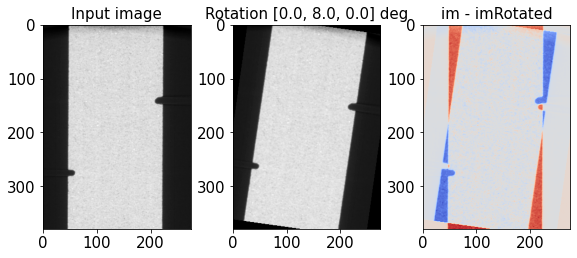

In [106]:
import spam.DIC

imDefR = spam.DIC.applyPhi(im, Phi=PhiR)

plt.figure(figsize=(8, 8))

plt.subplot(1,3,1); plt.title("Input image", fontsize=15)
plt.imshow(im[:, im.shape[1]//2], cmap="Greys_r")

plt.subplot(1,3,2); plt.title(f"Rotation {rotationVector} deg", fontsize=15)
plt.imshow(imDefR[:, imDefR.shape[1]//2], cmap="Greys_r")

plt.subplot(1,3,3); plt.title(f"im - imRotated", fontsize=15)
plt.imshow((im - imDefR)[:, imDefR.shape[1]//2], cmap="coolwarm")

plt.tight_layout(); plt.show()

### 3.4 Let's correlate two images!

We'll now try to **measure** the transformation between the pair of V4 images.<br>
These are X-ray tomography images of a sandstone performed before and after straining (credits E. Charalampidou).<br>

---
It should be already inside the folder `./V4`  <br>
If for any strange reason you can't find them, please download the `VEC4.zip` file from [here](https://zenodo.org/record/3888347).



### 3.4.1 Initial guess

First, we'll **measure** a **single** $\boldsymbol{\Phi}$ to perform an initial registration between the two images.<br>

---
For this, just for demonstration purposes, we'll call directly from <tt>bash</tt>:<br>
 - `spam-ereg`: a script that performs an **alignment by eye** between two images using a GUI
 - `spam-reg`: the registration script which applies the **iterative procedure** we mentioned previously 


In [4]:
! spam-ereg

/home/ostamati/Downloads/IntACT/V4/VEC4-01-b2.tif
('VEC4-01-b2', '.tif')


In [13]:
! spam-reg ./V4/VEC4-01-b2.tif ./V4/VEC4-02-b2.tif \
           -pf VEC4-01-b2-VEC4-02-b2-PhiEye.tsv \
           -m 20 \
           -def

spam-reg -- Current Settings:
	BIN_BEGIN: 4
	BIN_END: 1
	DEF: True
	GRAPH: False
	INTERPOLATION_ORDER: 1
	MARGIN: 20.0
	MASK1: None
	MAX_ITERATIONS: 50
	MIN_DELTA_PHI: 0.0001
	OUT_DIR: ./V4
	PHIFILE: <_io.TextIOWrapper name='VEC4-01-b2-VEC4-02-b2-PhiEye.tsv' mode='r' encoding='UTF-8'>
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: VEC4-01-b2-VEC4-02-b2-registration
	RIGID: False
	UPDATE_GRADIENT: False
	im1: <_io.TextIOWrapper name='./V4/VEC4-01-b2.tif' mode='r' encoding='UTF-8'>
	im2: <_io.TextIOWrapper name='./V4/VEC4-02-b2.tif' mode='r' encoding='UTF-8'>
	I read a registration from a file in binning 1.0
	Translations (px)
		 [0. 0. 0.]
	Rotations (deg)
		 [4. 0. 0.]
	Zoom
		 [1.0, 1.0, 1.0]
spam.DIC.correlate.registerMultiscale(): working on binning:  4
Start correlation with Error = 665.37
    Iteration Number:10   dPhiNorm=0.00006   error=199.94   t=[-0.028 0.528 -0.364]   r=[3.127 -0.393 0.007]   z=[1.000 1.001 1.003] (Elapsed Time: 0:00:00)
	 -> Converged
spam.DIC.correlate.registerMultiscale

### 3.4.2 Let's see the output files


In [93]:
!ls -l ./V4/*reg*

-rw-rw-r-- 1 ostamati ostamati 57538218 mai   29 17:12 ./V4/VEC4-01-b2-reg-def.tif
-rw-rw-r-- 1 ostamati ostamati      335 mai   29 17:12 ./V4/VEC4-01-b2-VEC4-02-b2-registration.tsv


In [7]:
# We'll load the registration result and read it
PhiFile = spam.helpers.readCorrelationTSV("./V4/VEC4-01-b2-VEC4-02-b2-registration.tsv") # let's read the .tsv
for key, value in list(PhiFile.items()): print(key,':',value) 


fieldDims : [1, 1, 1]
numberOfLabels : 1
fieldCoords : [[189.5 137.  137. ]]
returnStatus : 2.0
deltaPhiNorm : 2.79e-05
iterations : 4.0
PhiField : [[[ 0.994 -0.001 -0.008 -0.012]
  [ 0.     1.    -0.053  2.013]
  [ 0.009  0.053  1.002 -1.267]
  [ 0.     0.     0.     1.   ]]]


In [8]:
# Let's decompose the measured Φ
PhiReg = PhiFile["PhiField"][0]
for key, value in list(spam.deformation.decomposePhi(PhiReg).items())[:4]: print(key,':',value)

t : [-0.012  2.013 -1.267]
r : [ 3.037 -0.494  0.021]
z : [0.9937280630027907, 1.001141940944139, 1.0034648135531978]
U : [[ 0.994 -0.     0.   ]
 [-0.     1.001 -0.   ]
 [ 0.    -0.     1.003]]


### 3.4.3 Let's **evaluate** the registration result

That's very important! <br>
The code can converge (or at least not diverge), but this doesn't mean that we should always be happy with it! <br>

---
A very good indication for the correlation performance is the **residual field**.


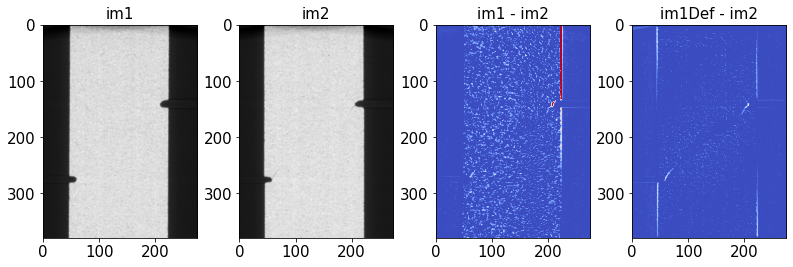

In [11]:
# Load images and calculate residuals
im1 = tifffile.imread("./V4/VEC4-01-b2.tif").astype(numpy.float32)
im2 = tifffile.imread("./V4/VEC4-02-b2.tif").astype(numpy.float32)
im1Def = tifffile.imread("./V4/VEC4-01-b2-reg-def.tif")

vmin, vmax = -im1.min()/4, im1.max()/4
plt.figure(figsize=(11, 11))
plt.subplot(1,4,1); plt.title("im1", fontsize=15)
plt.imshow(im1[:, im1.shape[1]//2], cmap="Greys_r")
plt.subplot(1,4,2); plt.title("im2", fontsize=15)
plt.imshow(im2[:, im2.shape[1]//2], cmap="Greys_r")
plt.subplot(1,4,3); plt.title("im1 - im2", fontsize=15)
plt.imshow((im1-im2)[:, im1.shape[1]//2], cmap="coolwarm", vmin=vmin, vmax=vmax)
plt.subplot(1,4,4); plt.title("im1Def - im2", fontsize=15)
plt.imshow((im1Def-im2)[:, im1.shape[1]//2], cmap="coolwarm", vmin=vmin, vmax=vmax)
plt.tight_layout(); plt.show()

### 3.5 What about a deformation **field** ?

Until now me measured a **single** deformation function that performs a **homogeneous** mapping of the material points from one configuration to the other.<br>

$ \hspace{1.5cm} \mathcal{T}(\boldsymbol{\Phi}) = \sum_{x \in \Omega} \left(f(x) - g(\boldsymbol{\Phi}\cdot x)\right)^2 \hspace{0.6cm} \text{and} \ \ x' = \boldsymbol{\Phi}\cdot x$

---
How do we end up measuring many points creating a deformation field?

Let's create a **grid** of points in our reference image:

<center>
    
<img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/regularGridSmall.png" width="320" height="320" />

### 3.5.1 Time to run the local correlation script called `spam-ldic`


In [74]:
! spam-ldic ./V4/VEC4-01-b2.tif ./V4/VEC4-02-b2.tif \
           -pf ./V4/VEC4-01-b2-VEC4-02-b2-registration.tsv \
           -hws 10 -ns 20 \
           -glt 20000 \
           -tif -vtk

spam-ldic -- Current Settings:
	APPLY_F: all
	GREY_HIGH_THRESH: inf
	GREY_LOW_THRESH: 20000.0
	HWS: [10, 10, 10]
	INTERPOLATION_ORDER: 1
	MARGIN: [3, 3, 3]
	MASK1: None
	MASK_COVERAGE: 0.5
	MAX_ITERATIONS: 50
	MIN_DELTA_PHI: 0.001
	NS: [20, 20, 20]
	OUT_DIR: ./V4
	PHIFILE: <_io.TextIOWrapper name='./V4/VEC4-01-b2-VEC4-02-b2-registration.tsv' mode='r' encoding='UTF-8'>
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: None
	PROCESSES: 8
	SERIES_INCREMENTAL: False
	SKIP_NODES: False
	TIFF: True
	TSV: True
	UPDATE_GRADIENT: False
	VTK: True
	inFiles: [<_io.TextIOWrapper name='./V4/VEC4-01-b2.tif' mode='r' encoding='UTF-8'>, <_io.TextIOWrapper name='./V4/VEC4-02-b2.tif' mode='r' encoding='UTF-8'>]

Correlating: VEC4-01-b2-VEC4-02-b2
	I read a registration from a file in binning 1.0
	Translations (px)
		 [-0.012  2.013 -1.267]
	Rotations (deg)
		 [ 3.037 -0.494  0.021]
	Zoom
		 [0.9937280630027907, 1.001141940944139, 1.0034648135531978]

	Starting local dic (with 8 processes)
  it=004  dPhiNorm=0.0004  rs=+

### 3.5.2 Let's see the `spam-ldic` output files


In [75]:
!ls -l ./V4/*ldic*

-rw-rw-r-- 1 ostamati ostamati  15514 mai   29 15:53 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-deltaPhiNorm.tif
-rw-rw-r-- 1 ostamati ostamati  12960 mai   28 00:59 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-dev-Q8.tif
-rw-rw-r-- 1 ostamati ostamati  15514 mai   29 15:53 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-error.tif
-rw-rw-r-- 1 ostamati ostamati  15514 mai   29 15:53 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-iterations.tif
-rw-rw-r-- 1 ostamati ostamati  15514 mai   29 15:53 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-returnStatus.tif
-rw-rw-r-- 1 ostamati ostamati 149273 mai   28 00:59 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-strain-Q8.tsv
-rw-rw-r-- 1 ostamati ostamati  76067 mai   28 00:59 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-strain-Q8.vtk
-rw-rw-r-- 1 ostamati ostamati 592990 mai   29 15:53 ./V4/VEC4-01-b2-VEC4-02-b2-ldic.tsv
-rw-rw-r-- 1 ostamati ostamati  12960 mai   28 00:59 ./V4/VEC4-01-b2-VEC4-02-b2-ldic-vol-Q8.tif
-rw-rw-r-- 1 ostamati ostamati 259936 mai   29 15:53 ./V4/VEC4-01-b2-VEC4-02-b2-ldic.vtk
-rw-rw-r-- 1 ostamati ostamati  1

### 3.5.3 Let's check the `spam-ldic` output **fields**


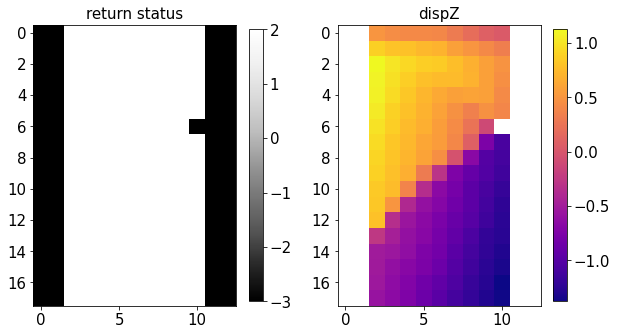

In [12]:
RS    = tifffile.imread("./V4/VEC4-01-b2-VEC4-02-b2-ldic-returnStatus.tif") # load return status field
dispZ = tifffile.imread("./V4/VEC4-01-b2-VEC4-02-b2-ldic-Zdisp.tif") # load Z displacement field

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.title("return status", fontsize=15)
plt.imshow(RS[:, RS.shape[1]//2], cmap="Greys_r", vmin=-3, vmax=2); plt.colorbar(shrink=0.5)
plt.subplot(1,2,2)
plt.title("dispZ", fontsize=15)
plt.imshow(dispZ[:, dispZ.shape[1]//2], cmap="plasma"); plt.colorbar(shrink=0.5)
plt.show()

### 3.5.4 Time for the `spam-ldic` residual **fields**

To produce deformed images, we have a dedicated script called `spam-deformImage`


In [79]:
! spam-deformImage ./V4/VEC4-01-b2.tif \
                  -pf ./V4/VEC4-01-b2-VEC4-02-b2-ldic.tsv \
                  -tet 

spam-deformImage: Current Settings:
	CORRECT_GREY_FOR_STRAIN: False
	INTERPOLATE_DISPLACEMENTS: False
	INTERPOLATION_ORDER: 1
	MASK2: None
	MESH_ALPHA: 0.0
	MESH_TRANSFORMATION: True
	NUMBER_OF_NEIGHBOURS: 8
	OUT_DIR: ./V4
	PHIFILE: <_io.TextIOWrapper name='./V4/VEC4-01-b2-VEC4-02-b2-ldic.tsv' mode='r' encoding='UTF-8'>
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: VEC4-01-b2
	PROCESSES: 8
	RADIUS: None
	RETURN_STATUS_THRESHOLD: 2
	RIGID: False
	inFile: <_io.TextIOWrapper name='./V4/VEC4-01-b2.tif' mode='r' encoding='UTF-8'>

	spam.tsvio.readCorrelationTSV(): Field dimensions: [18 13 13]
In PhiField mode.

spam-deformImage: excluding points based on return threshold < 2 (excluded 53.2%)
	nPoints =  1425
	nTets =  9349
	Generating labelled tet image... done
Interpolating image... done
Saving deformed image:
	./V4/VEC4-01-b2-tetMesh-def.tif


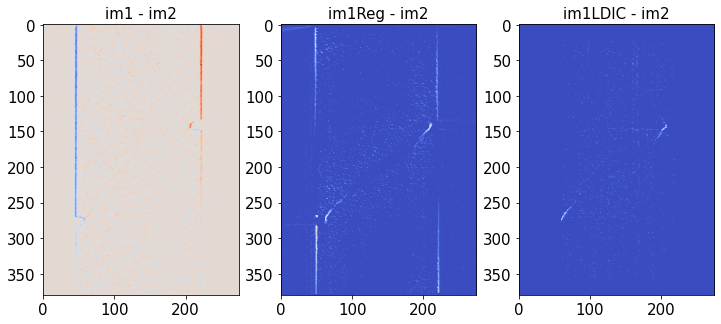

In [116]:
# Load images and calculate residuals
im1DefReg  = tifffile.imread("./V4/VEC4-01-b2-reg-def.tif")
im1DefLDIC = tifffile.imread("./V4/VEC4-01-b2-tetMesh-def.tif")

vmin, vmax = -im1.min()/3, im1.max()/3
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1); plt.title("im1 - im2", fontsize=15)
plt.imshow((im1-im2)[:, im2.shape[1]//2], cmap="coolwarm")
plt.subplot(1,3,2); plt.title("im1Reg - im2", fontsize=15)
plt.imshow((im1DefReg-im2)[:, im1.shape[0]//2], cmap="coolwarm", vmin=vmin, vmax=vmax)
plt.subplot(1,3,3); plt.title("im1LDIC - im2", fontsize=15)
plt.imshow((im1DefLDIC-im2)[:, im1.shape[1]//2], cmap="coolwarm", vmin=vmin, vmax=vmax)
plt.tight_layout(); plt.show()

### 3.6 Calculate a strain **field** 

The result of `spam-ldic` is a **field of deformation functions** $\boldsymbol{\Phi}$ measured at our defined grid points.<br>

By differentiating the decomposed **displacement field** we can obtain the **strain field**. <br>

---

This is again conveniently done by calling `spam-regularStrain` <br>

---
To read about the different strain calculation modes in <tt>SPAM</tt> and learn about the formulation of the strain invariants please check [this](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/tutorials/tutorial-07-strain.html}) tutorial.


In [87]:
! spam-regularStrain ./V4/VEC4-01-b2-VEC4-02-b2-ldic.tsv \
                    -cub \
                    -comp vol dev U \
                    -tif -vtk                 


+----------------------------+
| Regular Strain Calculation |
+----------------------------+

Current Settings:
	COMPONENTS: ['vol', 'dev', 'U']
	MASK: True
	OUT_DIR: ./V4
	PREFIX: VEC4-01-b2-VEC4-02-b2-ldic
	PROCESSES: 8
	Q8: True
	RAW: False
	RETURN_STATUS_THRESHOLD: 2
	STRAIN_NEIGHBOUR_RADIUS: 1.5
	TIFF: True
	TSV: True
	VTK: True
	VTKmaskNAN: True
	inFile: <_io.TextIOWrapper name='./V4/VEC4-01-b2-VEC4-02-b2-ldic.tsv' mode='r' encoding='UTF-8'>

spam-regularStrain: Loading data...
	spam.tsvio.readCorrelationTSV(): Field dimensions: [18 13 13]

spam-regularStrain: excluding points based on return threshold < 2 (excluded 46.8%)

spam-regularStrain: Computing F=I+du/dx
100% |#########################################################################|

spam-regularStrain: Decomposing F into  ['vol', 'dev', 'U']
100% |#########################################################################|

spam-regularStrain: Saving strain fields...


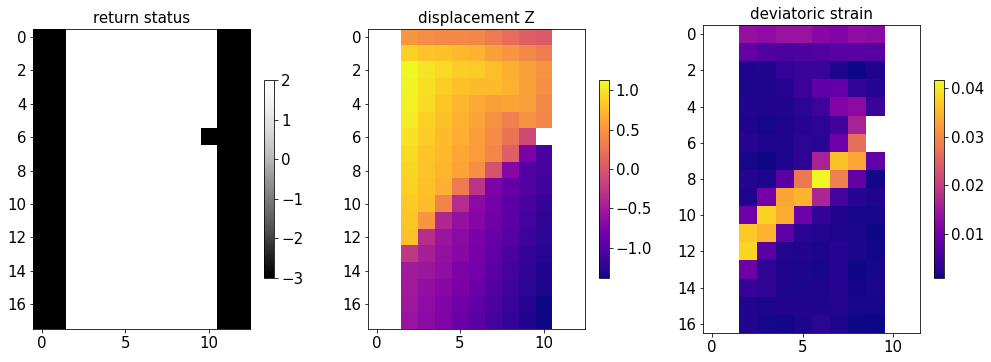

In [118]:
dev = tifffile.imread("./V4/VEC4-01-b2-VEC4-02-b2-ldic-dev-Q8.tif")

plt.figure(figsize=(14, 8))
plt.subplot(1,3,1); plt.title("return status", fontsize=15)
plt.imshow(RS[:, RS.shape[1]//2], cmap="Greys_r", vmin=-3, vmax=2); plt.colorbar(shrink=0.35)
plt.subplot(1,3,2); plt.title("displacement Z", fontsize=15)
plt.imshow(dispZ[:, dispZ.shape[1]//2], cmap="plasma"); plt.colorbar(shrink=0.35)
plt.subplot(1,3,3); plt.title("deviatoric strain", fontsize=15)
plt.imshow(dev[:, dev.shape[1]//2], cmap="plasma"); plt.colorbar(shrink=0.35)
plt.tight_layout(); plt.show()

### Don't forget that we're talking about 3D fields!

<table><tr>
<td> <img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/3d-disp.png" width="450" height="450" > </td>
<td> <img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/VEC4-01-b1-VEC4-02-b1-dev-Q8-3D.png" width="300" height="300" > </td>
</tr></table>